# A numerical study of fixation probabilities for strategies in the Prisoners  Dilemma

This notebook contains all the Python code used to generate the plots and figures for the paper.

Here are the versions of the various libraries used:

In [22]:
%matplotlib inline

import axelrod as axl
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import imp
players = imp.load_source('players', '../src/players.py')
generate_cache = imp.load_source('players', '../src/generate_cache.py')
theoretic = imp.load_source('theoretic', '../src/theoretic.py')

assert axl.__version__ == '2.9.0' 
assert pd.__version__ == '0.19.2'
assert matplotlib.__version__ == '2.0.0'
assert sns.__version__ == '0.7.1'
assert np.__version__ == '1.12.1'

## Description of the used strategies

Here are all the strategies used in this experiment:

In [23]:
from players import selected_players
players = selected_players()

assert len(players) == 172

In [24]:
players

[Adaptive,
 Adaptive Tit For Tat: 0.5,
 Aggravater,
 ALLCorALLD,
 Alternator,
 Alternator Hunter,
 AntiCycler,
 Anti Tit For Tat,
 Adaptive Pavlov 2006,
 Adaptive Pavlov 2011,
 Appeaser,
 Arrogant QLearner,
 Average Copier,
 Better and Better,
 BackStabber: ('D', 'D'),
 Bully,
 Calculator,
 Cautious QLearner,
 Champion,
 CollectiveStrategy,
 Contrite Tit For Tat,
 Cooperator,
 Cooperator Hunter,
 Cycle Hunter,
 Cycler CCCCCD,
 Cycler CCCD,
 Cycler CCD,
 Cycler DC,
 Cycler DDC,
 Cycler CCCDCD,
 Davis: 10,
 Defector,
 Defector Hunter,
 Desperate,
 DoubleCrosser: ('D', 'D'),
 Doubler,
 EasyGo,
 Eatherley,
 Eventual Cycle Hunter,
 Evolved ANN,
 Evolved ANN 5,
 Evolved ANN 5 Noise 05,
 Evolved FSM 4,
 Evolved FSM 16,
 Evolved FSM 16 Noise 05,
 EvolvedLookerUp1_1_1,
 EvolvedLookerUp2_2_2,
 Evolved HMM 5,
 Feld: 1.0, 0.5, 200,
 Firm But Fair,
 Fool Me Forever,
 Fool Me Once,
 Forgetful Fool Me Once: 0.05,
 Forgetful Grudger,
 Forgiver,
 Forgiving Tit For Tat,
 Fortress3,
 Fortress4,
 GTFT: 0.

In [25]:
with open("../tbl/list_of_players.tex", "w") as f:
    for player in players:
        latex_name = "{}\n".format(player).replace("_", "\_")
        f.write("\item {}".format(latex_name))

Here are some summary information about the strategies

In [26]:
def clean_mem(n):
    try:
        return int(n)
    except OverflowError:
        return -1

df = pd.DataFrame([[p, p.classifier["stochastic"], clean_mem(p.classifier['memory_depth'])] 
                   for p in players], 
                  columns=["Player", "Stochastic", "Memory Depth"])

In [27]:
t_df = pd.DataFrame(df.groupby("Stochastic")["Player"].count()).reset_index().rename(columns={"Player": "Count"})
t_df

,Stochastic,Count
0,False,123
1,True,49


In [28]:
with open("../tbl/stochastic_count.tex", "w") as f:
    f.write(t_df.to_latex(index=False))

In [29]:
t_df = pd.DataFrame(df.groupby("Memory Depth")["Player"].count()).transpose()
t_df.rename(index={"Player": "Count"}, inplace=True)
cols = t_df.columns.tolist()
t_df = t_df[cols[1:] + [cols[0]]]
t_df

Memory Depth,0,1,2,3,4,5,6,9,10,11,12,16,20,40,200,-1
Count,3,31,12,8,2,6,1,1,5,1,1,2,2,2,1,94


In [30]:
with open("../tbl/memory_depth_count.tex", "w") as f:
    string = t_df.to_latex().replace("-1", "\(\infty\)")
    f.write(string)

## Illustrating the Approximate moran process

In [31]:
df = pd.read_csv("../data/outcomes.csv", header=None, names=["Player 1", "Player 2", 
                                                             "Score 1", "Score 2", 
                                                             "Iteration"])

Get the counts of each number of 

In [32]:
t_df = pd.DataFrame(df.groupby(["Player 1", "Player 2"]).count()).reset_index()

In [33]:
max_pair = t_df.iloc[t_df["Score 1"].idxmax()][:2]
max_pair

Player 1            Risky QLearner
Player 2    Meta Hunter: 6 players
Name: 13103, dtype: object

In [34]:
min_pair = t_df.iloc[t_df["Score 1"].idxmin()][:2]
min_pair

Player 1    $\phi$
Player 2    $\phi$
Name: 0, dtype: object

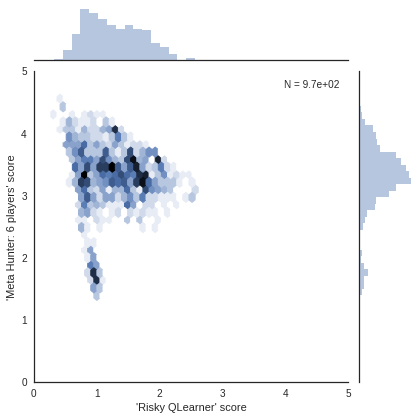

In [37]:
t_df = df[(df["Player 1"] == max_pair[0]) & (df["Player 2"] == max_pair[1])]

def N(x, y):
    return len(x)

sns.set(style="white", color_codes=True)
ax = sns.jointplot(t_df["Score 1"], t_df["Score 2"], stat_func=N, 
                   kind="hex", xlim=(0, 5), ylim=(0,5))
ax.set_axis_labels(*["\'{}\' score".format(max_pair[i][:25]) for i in range(2)])
ax.savefig("../img/players_with_most_scores.pdf");

In [38]:
len(t_df["Score 1"])

971

## Validating the model

Let us compute the fitness landscape for some strategy pairs and verify against the data.

We'll use the utilities from the pre computed match for the theoretic fixation.

In [16]:
utilities = {pair: (f["Score 1"].mean(), f["Score 2"].mean()) 
             for pair, f in df.groupby(["Player 1", "Player 2"])}

In [17]:
def simulated_fixation(strategy_pair, N, i=1, repetitions=10, 
                       cachefile=None):
    """Run a Moran process and obtain the fixation probabilities"""
    if cachefile is None:
        cachefile = "../data/outcomes.csv"
    
    cache = generate_cache.read_csv(cachefile)
    for k, v in cache.items():                                                          
        cache[k] = axl.Pdf(v)  
    
    players = []
    for _ in range(i):
        players.append(strategy_pair[0])
    for _ in range(N - i):
        players.append(strategy_pair[1])
    mp = axl.ApproximateMoranProcess(players, cached_outcomes=cache)
    
    win_count = 0
    for seed in range(repetitions):
        axl.seed(seed)
        mp.reset()
        mp.play()
        if mp.winning_strategy_name == players[0].name:
            win_count += 1
    
    return win_count / repetitions

Let us see how the simulated fixation compares to the theoretic fixation for a number of different population sizes.

In [18]:
def plot_theoretic_vs_simulated(players, max_N, repetitions):
    ns = range(2, max_N + 1, 2)
    repetitions = repetitions

    player_names = [p.__repr__() for p in players]
    calculated = [theoretic.fixation(player_names, n, n // 2, 
                                    utilities=utilities) 
                 for n in ns]
    simulated = [simulated_fixation(players,  n, n // 2, 
                                    repetitions=repetitions) 
                 for n in ns]
    plt.figure()
    plt.plot(ns, calculated, label="Theoretic $x_{N/2}$")
    plt.scatter(ns, simulated, label="Simulated $x_{N/2}$")


    plt.xlabel("Population size $N$")
    plt.title("Fixation probability for {} against {}".format(*[
        p[:25] for p in player_names]))
    plt.legend()
    plt.ylim(0, 1)
    return plt

In [19]:
max_N = 16
repetitions = 1000

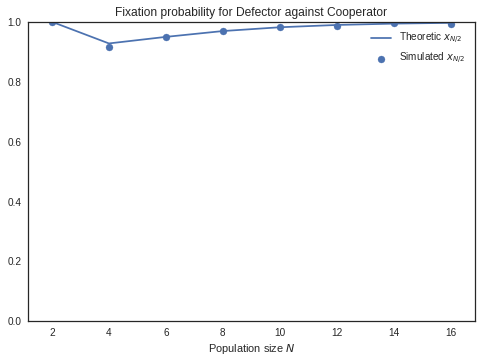

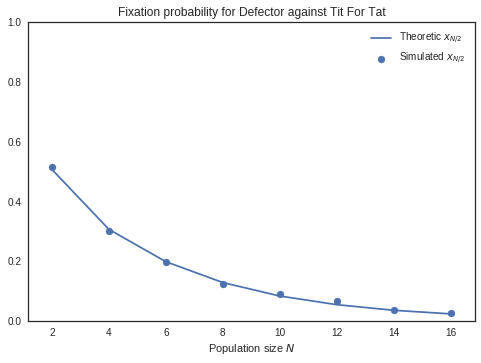

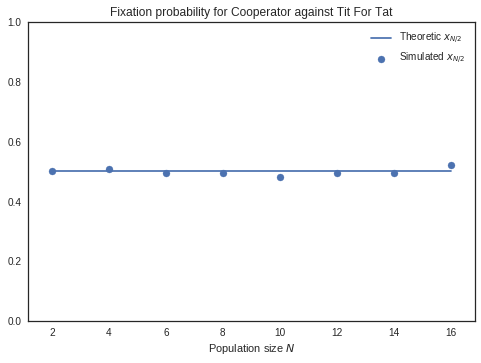

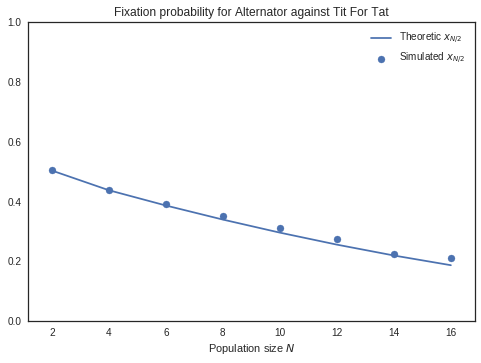

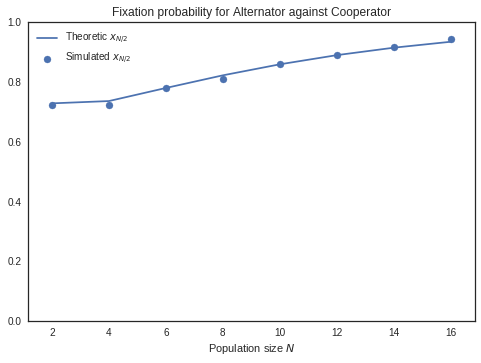

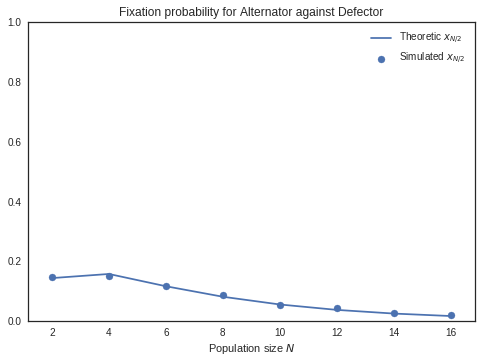

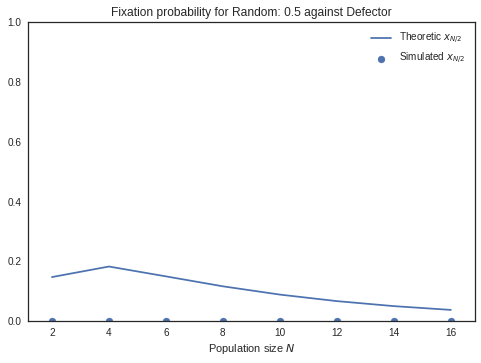

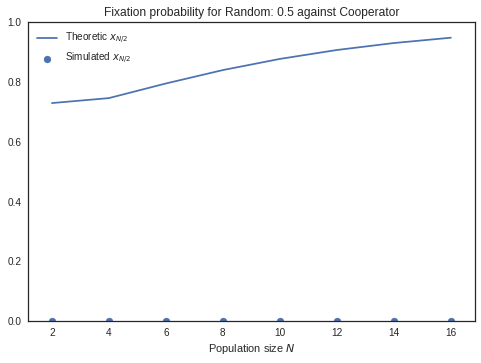

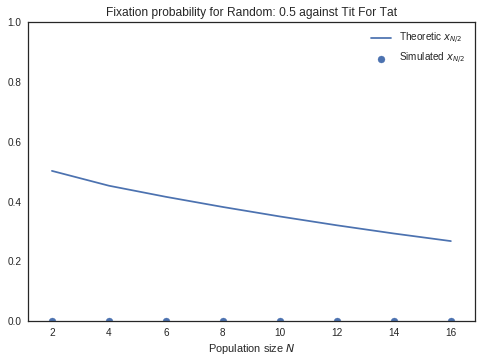

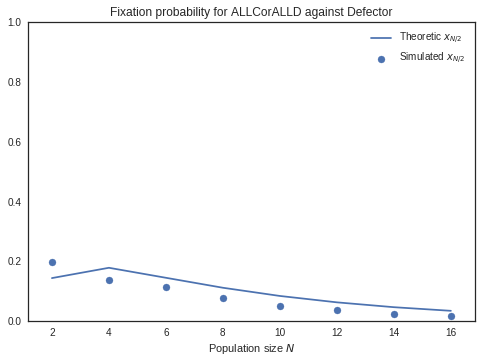

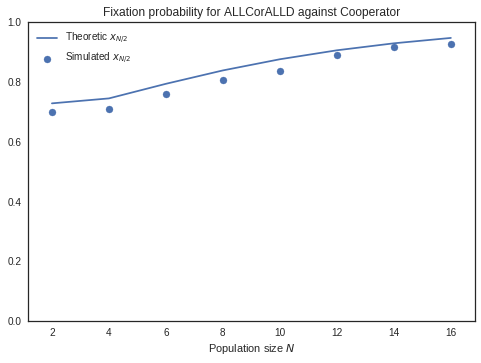

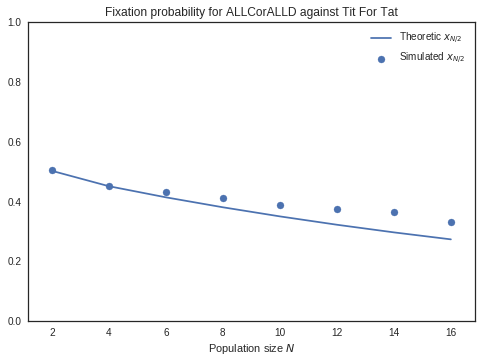

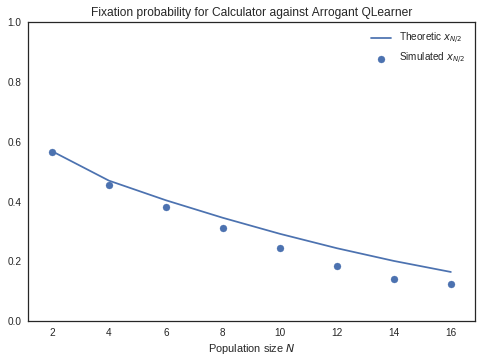

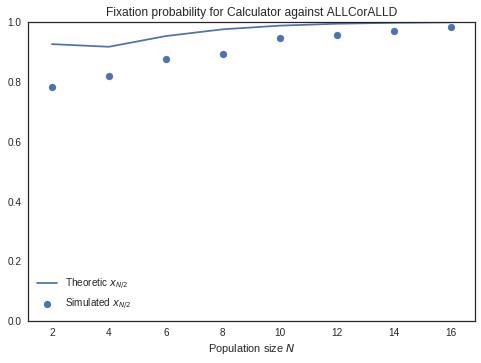

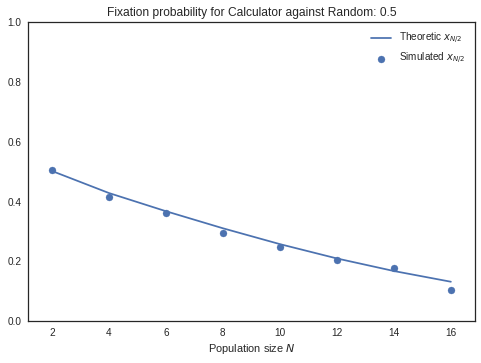

In [21]:
max_player_pair = [p for p in players if p.__repr__() in list(max_pair)]

for pair in [(axl.Defector(), axl.Cooperator()),
             (axl.Defector(), axl.TitForTat()),
             (axl.Cooperator(), axl.TitForTat()),
             (axl.Alternator(), axl.TitForTat()),
             (axl.Alternator(), axl.Cooperator()),
             (axl.Alternator(), axl.Defector()),
             (axl.Random(), axl.Defector()),
             (axl.Random(), axl.Cooperator()),
             (axl.Random(), axl.TitForTat()),
             (axl.ALLCorALLD(), axl.Defector()),
             (axl.ALLCorALLD(), axl.Cooperator()),
             (axl.ALLCorALLD(), axl.TitForTat()),
             (axl.Calculator(), axl.ArrogantQLearner()),
             (axl.Calculator(), axl.ALLCorALLD()),
             (axl.Calculator(), axl.Random())]:
    p = plot_theoretic_vs_simulated(pair, max_N=max_N, 
                                    repetitions=repetitions)
    names = [p.__repr__() for p in pair]
    filename = "../img/{}_v_{}_{}_repetitions".format(*names, repetitions)
    filename.replace(":", "_")
    filename.replace(".", "_")
    filename.replace(" ", "_")
    filename += ".pdf"
    p.savefig(filename)